In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import clip
import torch
import torch.nn.functional as F
import clip
import numpy as np
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
# pip install git+https://github.com/openai/CLIP.git torchvision torch umap-learn scikit-learn matplotlib
import random
from torch.utils.data import DataLoader, Subset
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap
from scipy.linalg import orthogonal_procrustes

In [2]:
_, preprocess = clip.load("ViT-B/32", device='cuda')
stl10_train = torchvision.datasets.STL10(root='./stl_data', split='train', download=True, transform=preprocess)
stl10_test = torchvision.datasets.STL10(root='./stl_data', split='test', download=True, transform=preprocess)

Using device: cuda
CLIP model loaded successfully
STL-10 test set loaded: 8000 samples
CLIP Zero-Shot Evaluation on STL-10

Evaluating with 'plain' prompting strategy...
Text prompts:
  airplane: 'airplane'
  bird: 'bird'
  car: 'car'
  cat: 'cat'
  deer: 'deer'
  dog: 'dog'
  horse: 'horse'
  monkey: 'monkey'
  ship: 'ship'
  truck: 'truck'


Evaluating: 100%|██████████| 125/125 [00:03<00:00, 35.66it/s]


Accuracy with 'plain': 0.9625 (96.25%)

Evaluating with 'simple_template' prompting strategy...
Text prompts:
  airplane: 'a photo of a airplane'
  bird: 'a photo of a bird'
  car: 'a photo of a car'
  cat: 'a photo of a cat'
  deer: 'a photo of a deer'
  dog: 'a photo of a dog'
  horse: 'a photo of a horse'
  monkey: 'a photo of a monkey'
  ship: 'a photo of a ship'
  truck: 'a photo of a truck'


Evaluating: 100%|██████████| 125/125 [00:03<00:00, 34.71it/s]


Accuracy with 'simple_template': 0.9735 (97.35%)

Evaluating with 'descriptive' prompting strategy...
Text prompts:
  airplane: 'a photo of an airplane flying in the sky'
  bird: 'a photo of a colorful bird with wings'
  car: 'a photo of a modern car on the road'
  cat: 'a photo of a cute domestic cat with fur'
  deer: 'a photo of a graceful deer in nature'
  dog: 'a photo of a friendly dog with a wagging tail'
  horse: 'a photo of a majestic horse running'
  monkey: 'a photo of a playful monkey in trees'
  ship: 'a photo of a large ship sailing on water'
  truck: 'a photo of a heavy truck on highway'


Evaluating: 100%|██████████| 125/125 [00:03<00:00, 34.09it/s]


Accuracy with 'descriptive': 0.9364 (93.64%)

Evaluating with 'context_rich' prompting strategy...
Text prompts:
  airplane: 'a high-quality photograph of a commercial airplane during flight'
  bird: 'a detailed image of a wild bird with beautiful plumage'
  car: 'a clear photograph of an automobile vehicle'
  cat: 'a portrait of a house cat with whiskers and pointed ears'
  deer: 'a wildlife photograph of a deer with antlers in forest'
  dog: 'a photograph of a domestic dog breed with four legs'
  horse: 'an image of an equine animal with a mane'
  monkey: 'a photograph of a primate swinging through trees'
  ship: 'a maritime photograph of a vessel on ocean waters'
  truck: 'a photograph of a large motor vehicle for cargo transport'


Evaluating: 100%|██████████| 125/125 [00:03<00:00, 33.40it/s]


Accuracy with 'context_rich': 0.9019 (90.19%)

RESULTS COMPARISON
plain               : 0.9625 (96.25%)
simple_template     : 0.9735 (97.35%)
descriptive         : 0.9364 (93.64%)
context_rich        : 0.9019 (90.19%)

Best strategy: simple_template with 0.9735 accuracy

PER-CLASS ANALYSIS

PLAIN Strategy:
  airplane  : 0.951
  bird      : 0.998
  car       : 0.948
  cat       : 0.844
  deer      : 0.985
  dog       : 0.966
  horse     : 0.990
  monkey    : 0.949
  ship      : 0.999
  truck     : 0.996

SIMPLE_TEMPLATE Strategy:
  airplane  : 0.984
  bird      : 0.998
  car       : 0.971
  cat       : 0.896
  deer      : 0.973
  dog       : 0.968
  horse     : 0.991
  monkey    : 0.970
  ship      : 0.999
  truck     : 0.986

DESCRIPTIVE Strategy:
  airplane  : 0.841
  bird      : 0.973
  car       : 0.989
  cat       : 0.891
  deer      : 0.953
  dog       : 0.958
  horse     : 0.911
  monkey    : 0.906
  ship      : 0.999
  truck     : 0.944

CONTEXT_RICH Strategy:
  airplane  : 0.92

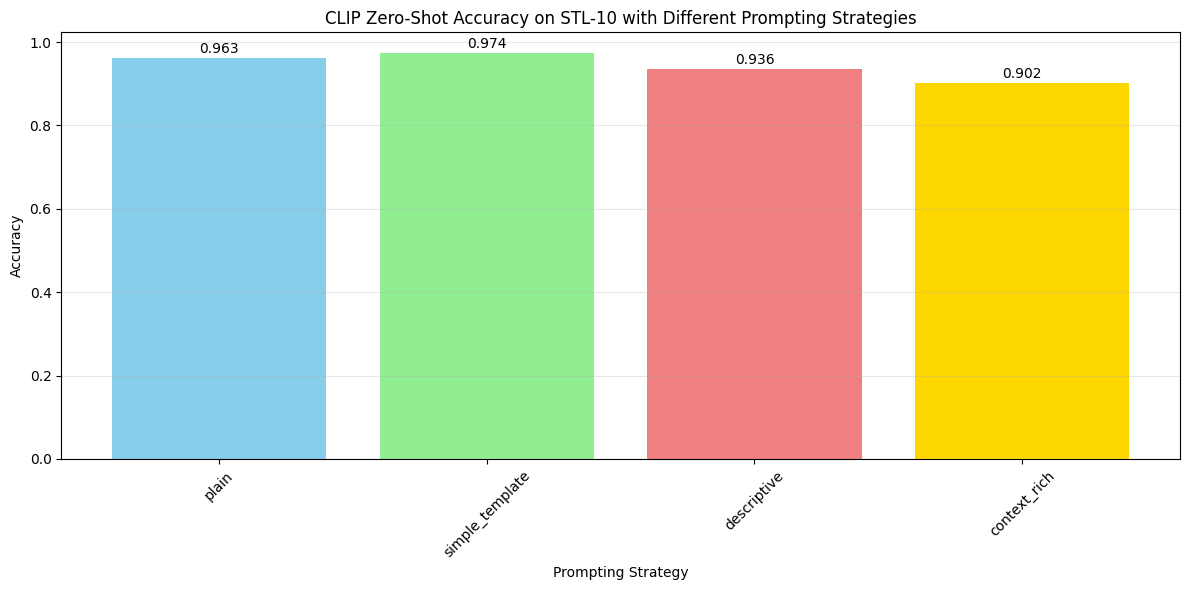

In [3]:
class STL10CLIPEvaluator:
    def __init__(self, device=None):
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Load CLIP model
        self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)
        print("CLIP model loaded successfully")
        
        # STL-10 class names
        self.class_names = [
            "airplane", "bird", "car", "cat", "deer", 
            "dog", "horse", "monkey", "ship", "truck"
        ]
        
    def load_stl10_data(self, batch_size=64):
        """Load STL-10 test dataset"""
        test_loader = DataLoader(
            stl10_test, 
            batch_size=batch_size, 
            shuffle=False, 
            num_workers=2
        )
        
        print(f"STL-10 test set loaded: {len(stl10_test)} samples")
        return test_loader
    
    def create_text_prompts(self, strategy="plain"):
        """Create text prompts based on different strategies"""
        prompts = []
        
        if strategy == "plain":
            # Strategy 1: Plain labels
            prompts = self.class_names
            
        elif strategy == "simple_template":
            # Strategy 2: Simple template
            template = "a photo of a {}"
            prompts = [template.format(class_name) for class_name in self.class_names]
            
        elif strategy == "descriptive":
            # Strategy 3: More descriptive prompts
            descriptive_prompts = {
                "airplane": "a photo of an airplane flying in the sky",
                "bird": "a photo of a colorful bird with wings",
                "car": "a photo of a modern car on the road",
                "cat": "a photo of a cute domestic cat with fur",
                "deer": "a photo of a graceful deer in nature",
                "dog": "a photo of a friendly dog with a wagging tail",
                "horse": "a photo of a majestic horse running",
                "monkey": "a photo of a playful monkey in trees",
                "ship": "a photo of a large ship sailing on water",
                "truck": "a photo of a heavy truck on highway"
            }
            prompts = [descriptive_prompts[class_name] for class_name in self.class_names]
            
        elif strategy == "context_rich":
            # Strategy 4: Context-rich prompts
            context_prompts = {
                "airplane": "a high-quality photograph of a commercial airplane during flight",
                "bird": "a detailed image of a wild bird with beautiful plumage",
                "car": "a clear photograph of an automobile vehicle",
                "cat": "a portrait of a house cat with whiskers and pointed ears",
                "deer": "a wildlife photograph of a deer with antlers in forest",
                "dog": "a photograph of a domestic dog breed with four legs",
                "horse": "an image of an equine animal with a mane",
                "monkey": "a photograph of a primate swinging through trees",
                "ship": "a maritime photograph of a vessel on ocean waters",
                "truck": "a photograph of a large motor vehicle for cargo transport"
            }
            prompts = [context_prompts[class_name] for class_name in self.class_names]
            
        return prompts
    
    def evaluate_zero_shot(self, test_loader, prompting_strategy="plain"):
        """Evaluate CLIP with zero-shot classification"""
        print(f"\nEvaluating with '{prompting_strategy}' prompting strategy...")
        
        # Create text prompts
        text_prompts = self.create_text_prompts(prompting_strategy)
        print("Text prompts:")
        for i, prompt in enumerate(text_prompts):
            print(f"  {self.class_names[i]}: '{prompt}'")
        
        # Encode text prompts
        text_tokens = clip.tokenize(text_prompts).to(self.device)
        
        with torch.no_grad():
            text_features = self.model.encode_text(text_tokens)
            text_features = F.normalize(text_features, dim=-1)
        
        correct_predictions = 0
        total_predictions = 0
        all_predictions = []
        all_labels = []
        
        self.model.eval()
        
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Evaluating"):
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                # Encode images
                image_features = self.model.encode_image(images)
                image_features = F.normalize(image_features, dim=-1)
                
                # Calculate similarity scores
                logits = image_features @ text_features.T
                predictions = logits.argmax(dim=-1)
                
                # Calculate accuracy
                correct_predictions += (predictions == labels).sum().item()
                total_predictions += labels.size(0)
                
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        accuracy = correct_predictions / total_predictions
        print(f"Accuracy with '{prompting_strategy}': {accuracy:.4f} ({accuracy*100:.2f}%)")
        
        return accuracy, all_predictions, all_labels
    
    def run_comprehensive_evaluation(self):
        """Run evaluation with multiple prompting strategies"""
        # Load data
        test_loader = self.load_stl10_data()
        
        strategies = ["plain", "simple_template", "descriptive", "context_rich"]
        results = {}
        
        print("="*60)
        print("CLIP Zero-Shot Evaluation on STL-10")
        print("="*60)
        
        for strategy in strategies:
            accuracy, predictions, labels = self.evaluate_zero_shot(test_loader, strategy)
            results[strategy] = {
                'accuracy': accuracy,
                'predictions': predictions,
                'labels': labels
            }
        
        # Display comparison
        print("\n" + "="*60)
        print("RESULTS COMPARISON")
        print("="*60)
        
        for strategy, result in results.items():
            print(f"{strategy:20s}: {result['accuracy']:.4f} ({result['accuracy']*100:.2f}%)")
        
        # Find best strategy
        best_strategy = max(results.keys(), key=lambda x: results[x]['accuracy'])
        best_accuracy = results[best_strategy]['accuracy']
        
        print(f"\nBest strategy: {best_strategy} with {best_accuracy:.4f} accuracy")
        
        return results
    
    def analyze_per_class_performance(self, results):
        """Analyze per-class performance for different strategies"""
        print("\n" + "="*60)
        print("PER-CLASS ANALYSIS")
        print("="*60)
        
        for strategy, result in results.items():
            print(f"\n{strategy.upper()} Strategy:")
            predictions = np.array(result['predictions'])
            labels = np.array(result['labels'])
            
            for i, class_name in enumerate(self.class_names):
                class_mask = labels == i
                class_predictions = predictions[class_mask]
                class_accuracy = (class_predictions == i).mean() if class_mask.sum() > 0 else 0
                print(f"  {class_name:10s}: {class_accuracy:.3f}")

def create_results_visualization(results):
    """Create a bar chart comparing different prompting strategies"""
    strategies = list(results.keys())
    accuracies = [results[strategy]['accuracy'] for strategy in strategies]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(strategies, accuracies, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    
    # Add value labels on bars
    for bar, accuracy in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                f'{accuracy:.3f}', ha='center', va='bottom')
    
    plt.title('CLIP Zero-Shot Accuracy on STL-10 with Different Prompting Strategies')
    plt.xlabel('Prompting Strategy')
    plt.ylabel('Accuracy')
    plt.ylim(0, max(accuracies) + 0.05)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

evaluator = STL10CLIPEvaluator()
# Run comprehensive evaluation
results = evaluator.run_comprehensive_evaluation()
# Analyze per-class performance
evaluator.analyze_per_class_performance(results)
# Create visualization
create_results_visualization(results)


=== Modality gap quick metrics ===
Mean cosine (image raw  vs matched text): 0.264
Mean cosine (image L2   vs matched text): 0.264
Mean cosine (image L2   vs mismatched  ): 0.192
Avg margin (pos - neg, normalized): 0.071
Cos(mean_img_raw,  mean_text): 0.269
Cos(mean_img_norm, mean_text): 0.269


/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_1220799/1154376611.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", 10)


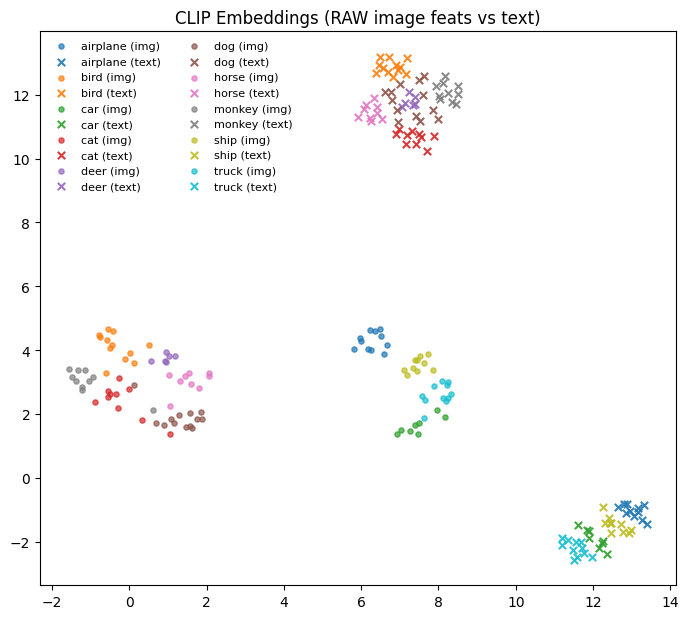

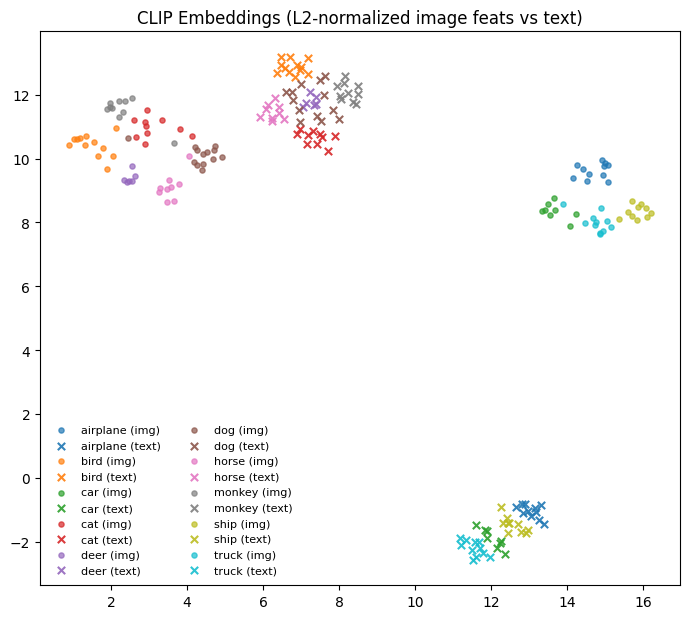

In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=DEVICE)
classes = ["airplane","bird","car","cat","deer","dog","horse","monkey","ship","truck"]

@torch.no_grad()
def build_text_prototypes(classnames):
    """Return [C, D] normalized text prototypes for each class (prompt-ensemble averaged)."""
    zs = []
    for cname in classnames:
        text = f"a photo of a {cname}"
        tok = clip.tokenize(text).to(DEVICE)
        te = model.encode_text(tok)                # [T, D]
        te = te / te.norm(dim=-1, keepdim=True)    # L2 per prompt
        te = te.mean(dim=0)                        # average prompts
        te = te / te.norm()                        # final normalized prototype
        zs.append(te)
    return torch.stack(zs, dim=0)                  # [C, D]

# --- Data: take 50-100 samples from STL-10 test ---
FULL_TEST = stl10_test
N = 100  # set 50..100
idxs = np.random.choice(len(FULL_TEST), size=N, replace=False)
TEST = Subset(FULL_TEST, idxs)
loader = DataLoader(TEST, batch_size=128, shuffle=False, num_workers=2)

# --- Extract embeddings ---
@torch.no_grad()
def collect_embeddings():
    text_protos = build_text_prototypes(classes)   # [C, D], L2-normalized
    X_img, X_txt, y = [], [], []

    for ims, labels in loader:
        ims = ims.to(DEVICE); labels = labels.to(DEVICE)
        z_img = model.encode_image(ims)                       # [B, D]
        # raw (un-normalized) image feats kept; we’ll also store normalized versions
        X_img.append(z_img.detach().cpu().numpy())
        # For each label, pick the corresponding text prototype (one per class)
        X_txt.append(text_protos[labels].detach().cpu().numpy())
        y.append(labels.detach().cpu().numpy())

    X_img = np.concatenate(X_img, axis=0)  # [N, D]
    X_txt = np.concatenate(X_txt, axis=0)  # [N, D] (repeated class prototypes per sample)
    y = np.concatenate(y, axis=0)          # [N]
    return X_img, X_txt, y, text_protos.cpu().numpy()

X_img_raw, X_txt_norm, y, text_protos_norm = collect_embeddings()
# Normalize image embeddings as well (direction-only view)
X_img_norm = X_img_raw / np.linalg.norm(X_img_raw, axis=1, keepdims=True)

# --- Simple quantitative “gap” metrics ---
def cosine(a, b):
    a = a / np.linalg.norm(a, axis=1, keepdims=True)
    b = b / np.linalg.norm(b, axis=1, keepdims=True)
    return np.sum(a*b, axis=1)

# Pair each image with its matching class prototype:
paired_txt = text_protos_norm[y]                 # [N, D]
pos_cos_raw = cosine(X_img_raw, paired_txt)      # BEFORE L2 on images
pos_cos_norm = cosine(X_img_norm, paired_txt)    # AFTER L2 on images

# Imposter negatives: match each image to a prototype from a *different* class
SEED = 42
rng = np.random.default_rng(SEED)
neg_labels = np.array([rng.choice([c for c in range(10) if c != yy]) for yy in y])
neg_txt = text_protos_norm[neg_labels]
neg_cos_norm = cosine(X_img_norm, neg_txt)

print("\n=== Modality gap quick metrics ===")
print(f"Mean cosine (image raw  vs matched text): {pos_cos_raw.mean():.3f}")
print(f"Mean cosine (image L2   vs matched text): {pos_cos_norm.mean():.3f}")
print(f"Mean cosine (image L2   vs mismatched  ): {neg_cos_norm.mean():.3f}")
print(f"Avg margin (pos - neg, normalized): {(pos_cos_norm - neg_cos_norm).mean():.3f}")

# Angle between global means (another coarse proxy)
mean_img_raw  = X_img_raw.mean(axis=0);  mean_img_raw  /= np.linalg.norm(mean_img_raw)
mean_img_norm = X_img_norm.mean(axis=0); mean_img_norm /= np.linalg.norm(mean_img_norm)
mean_txt = text_protos_norm.mean(axis=0); mean_txt /= np.linalg.norm(mean_txt)
print(f"Cos(mean_img_raw,  mean_text): {float(mean_img_raw @ mean_txt):.3f}")
print(f"Cos(mean_img_norm, mean_text): {float(mean_img_norm @ mean_txt):.3f}")

# --- 2D projection helper (UMAP or TSNE). Optionally PCA->TSNE for stability ---
def project_2d(X):
    reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, metric="cosine", random_state=SEED)
    return reducer.fit_transform(X)

# --- Visualize: per-sample images vs their (repeated) text prototypes ---
def plot_overlay(Z_img, Z_txt, labels, title, savepath=None):
    plt.figure(figsize=(7.0, 6.3))
    # color by class; circles=image, x=text
    cmap = plt.cm.get_cmap("tab10", 10)
    for c in range(10):
        m_img = labels==c
        m_txt = labels==c
        plt.scatter(Z_img[m_img,0], Z_img[m_img,1], s=14, alpha=0.7, label=f"{classes[c]} (img)", c=[cmap(c)])
        plt.scatter(Z_txt[m_txt,0], Z_txt[m_txt,1], s=28, alpha=0.9, marker="x", label=f"{classes[c]} (text)", c=[cmap(c)])
    plt.title(title)
    plt.legend(ncol=2, fontsize=8, frameon=False)
    plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=180)
    plt.show()

# --- Project and plot (RAW vs L2-normalized image feats) ---
Z_img_raw  = project_2d(X_img_raw)
Z_img_norm = project_2d(X_img_norm)
Z_txt_rep  = project_2d(X_txt_norm)  # repeated class prototypes (one per sample)

plot_overlay(Z_img_raw,  Z_txt_rep, y, title="CLIP Embeddings (RAW image feats vs text)")
plot_overlay(Z_img_norm, Z_txt_rep, y, title="CLIP Embeddings (L2-normalized image feats vs text)")


/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/csalt/anaconda3/envs/atml_pa0/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_1220799/1331241956.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", 10)


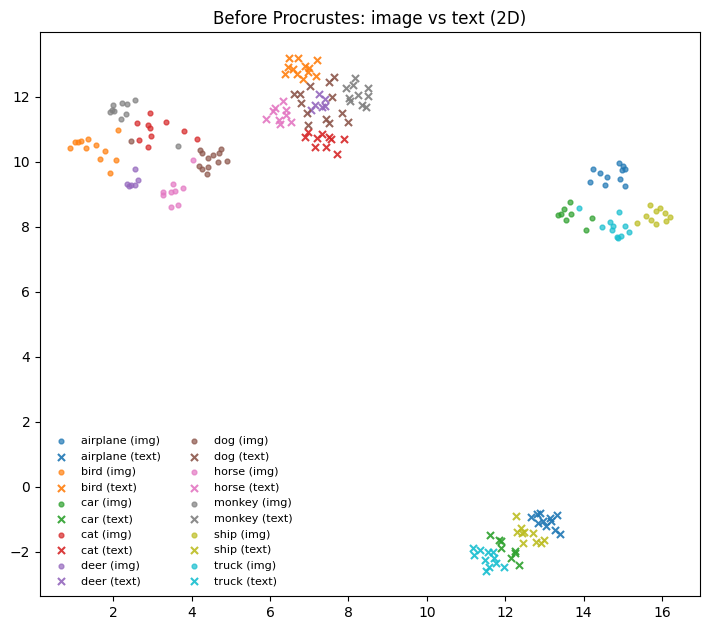

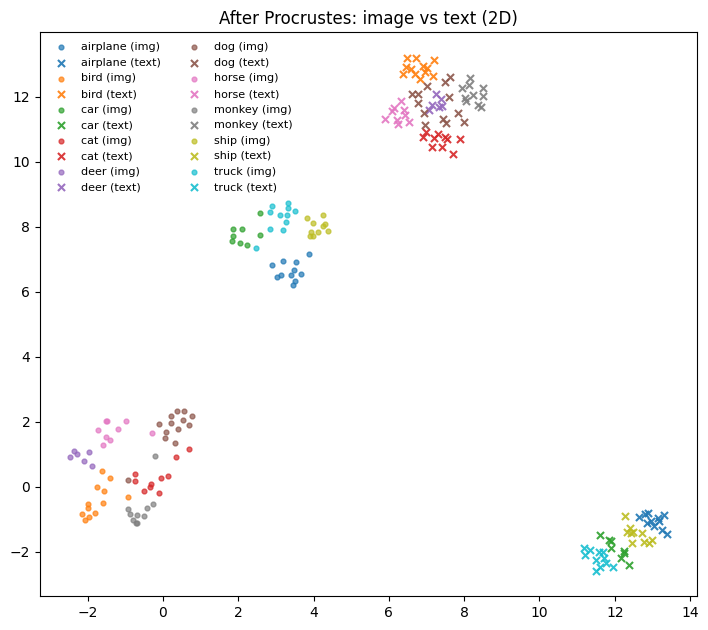


=== Procrustes Alignment: Summary ===
Top-1 accuracy (before): 96.00%
Top-1 accuracy (after) : 97.00%
Mean cos (matched) before: 0.264 | after: 0.125
Mean cos (mismatched) before: 0.192 | after: -0.024
Avg margin (matched - mismatched) before: 0.071
Avg margin (matched - mismatched) after : 0.149


In [9]:
@torch.no_grad()
def collect_all():
    text_protos = build_text_prototypes(classes)    # [C, D], L2
    X_img, y = [], []
    for ims, labels in loader:
        ims = ims.to(DEVICE)
        z = model.encode_image(ims)                             # [B, D] (raw)
        X_img.append(z.cpu().numpy())
        y.append(labels.numpy())
    X_img = np.concatenate(X_img, axis=0)                      # [N, D]
    y = np.concatenate(y, axis=0)                              # [N]
    X_txt = text_protos.cpu().numpy()[y]                       # [N, D], repeated class proto
    # Also keep the per-class matrix once (not repeated)
    class_text = text_protos.cpu().numpy()                     # [C, D]
    return X_img, X_txt, y, class_text

X_img_raw, X_txt_norm_rep, y, class_text_norm = collect_all()
N, D = X_img_raw.shape

# L2-normalized image features (cosine space)
X_img_norm = X_img_raw / np.linalg.norm(X_img_raw, axis=1, keepdims=True)

# ---------- (a)-(c) Learn orthogonal R via Procrustes on a small FIT subset ----------
# Pair images with their *matched* text (same label). We’ll fit on normalized rows.
FIT_SIZE = 100    
fit_idx = np.random.choice(N, size=min(FIT_SIZE, N), replace=False)
X_fit = X_img_norm[fit_idx]                      # [K, D]
Y_fit = X_txt_norm_rep[fit_idx]                  # [K, D] (matched text prototypes)

# Optional mean-centering (classical Procrustes with translation); try both:
def orthogonal_R(X, Y, center=True):
    Xc, Yc = X.copy(), Y.copy()
    if center:
        Xc -= Xc.mean(axis=0, keepdims=True)
        Yc -= Yc.mean(axis=0, keepdims=True)
    R, _ = orthogonal_procrustes(Xc, Yc)         # solve min ||X R - Y||_F s.t. R^T R = I
    return R

R = orthogonal_R(X_fit, Y_fit, center=True)

# ---------- (d) Apply rotation to all image features ----------
X_img_rot = X_img_norm @ R                      # still unit-norm? (R is orthogonal) -> preserve norms
# Re-normalize to mitigate numeric drift:
X_img_rot = X_img_rot / np.linalg.norm(X_img_rot, axis=1, keepdims=True)

# ---------- Helpers: projection & plotting ----------
def project_2d(X, seed=SEED):
    reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, metric="cosine", random_state=seed)
    return reducer.fit_transform(X)

def plot_overlay(Z_img, Z_txt_rep, labels, title, savepath=None):
    plt.figure(figsize=(7.2, 6.4))
    cmap = plt.cm.get_cmap("tab10", 10)
    for c in range(10):
        m = (labels == c)
        plt.scatter(Z_img[m,0], Z_img[m,1], s=12, alpha=0.7, c=[cmap(c)], label=f"{classes[c]} (img)")
        plt.scatter(Z_txt_rep[m,0], Z_txt_rep[m,1], s=26, alpha=0.9, c=[cmap(c)], marker="x", label=f"{classes[c]} (text)")
    plt.title(title)
    plt.legend(ncol=2, fontsize=8, frameon=False)
    plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=180)
    plt.show()

# ---------- (e) Visualize: BEFORE vs AFTER alignment ----------
Z_img_before = project_2d(X_img_norm)
Z_img_after  = project_2d(X_img_rot)
Z_txt_rep    = project_2d(X_txt_norm_rep)

plot_overlay(Z_img_before, Z_txt_rep, y, "Before Procrustes: image vs text (2D)")
plot_overlay(Z_img_after,  Z_txt_rep, y, "After Procrustes: image vs text (2D)")

# ---------- (f) Accuracy: BEFORE vs AFTER ----------
# Zero-shot: compare image features to PER-CLASS text prototypes
def top1_accuracy(X_img_feats, class_text_norm, labels):
    # cosine logits = dot because both are L2-normalized
    logits = X_img_feats @ class_text_norm.T             # [N, C]
    preds = logits.argmax(axis=1)
    return (preds == labels).mean()

# (1) Normalize class_text (already unit) and image feats (we ensured unit)
acc_before = top1_accuracy(X_img_norm, class_text_norm, y)
acc_after  = top1_accuracy(X_img_rot,  class_text_norm, y)

# Some quick “gap” metrics
def cosine(a, b):
    a = a / np.linalg.norm(a, axis=1, keepdims=True)
    b = b / np.linalg.norm(b, axis=1, keepdims=True)
    return np.sum(a*b, axis=1)

matched_text = class_text_norm[y]
pos_cos_before = cosine(X_img_norm, matched_text)
pos_cos_after  = cosine(X_img_rot,  matched_text)

rng = np.random.default_rng(SEED)
neg_labels = np.array([rng.choice([c for c in range(10) if c != yy]) for yy in y])
neg_text = class_text_norm[neg_labels]
neg_cos_before = cosine(X_img_norm, neg_text)
neg_cos_after  = cosine(X_img_rot,  neg_text)

print("\n=== Procrustes Alignment: Summary ===")
print(f"Top-1 accuracy (before): {acc_before*100:.2f}%")
print(f"Top-1 accuracy (after) : {acc_after*100:.2f}%")
print(f"Mean cos (matched) before: {pos_cos_before.mean():.3f} | after: {pos_cos_after.mean():.3f}")
print(f"Mean cos (mismatched) before: {neg_cos_before.mean():.3f} | after: {neg_cos_after.mean():.3f}")
print(f"Avg margin (matched - mismatched) before: {(pos_cos_before - neg_cos_before).mean():.3f}")
print(f"Avg margin (matched - mismatched) after : {(pos_cos_after  - neg_cos_after ).mean():.3f}")
